In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1.Preparation

## 1.1 Functions

In [ ]:
!pip install pyro-ppl

In [ ]:
import torch
import pyro
pyro.__version__

'1.5.1'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from pyro.nn import PyroModule, PyroSample, PyroParam
import pyro.distributions as dist

In [ ]:
def visualize(loss_track, param_track, approx):
    plt.plot(range(len(loss_track)), loss_track)
    plt.title('Loss')
    plt.show()

    param_names = param_track[0].keys()
    for param_name in param_names:
        param_value = [param[param_name] for param in param_track]
        plt.plot(range(len(param_value)), param_value)
        plt.title(param_name)
        plt.show()
    for dim in range(approx.shape[1]):
        plt.hist(approx[:, dim])
        plt.show()

In [ ]:
def get_muvar(x):
    mu, var = torch.mean(x), torch.var(x)
    return mu, var

def log_norm(x, mu, var):
    """Compute the log pdf of x,
    under a normal distribution with mean mu and standard deviation std."""
    return -0.5 * torch.log(2*np.pi*var) -(0.5 * (1/var)* (x-mu)**2)

In [ ]:
# see torch.nn.KLDivLoss
class KLDiv_Loss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean', log_target: bool = False):
        super(KLDiv_Loss, self).__init__(size_average, reduce, reduction)
        self.log_target = log_target

    def forward(self, input, target):
        mu_p, var_p = get_muvar(target)
        log_p = log_norm(target, mu_p, var_p)
        mu_q, var_q = get_muvar(target)
        log_q = log_norm(input, mu_q, var_q)
        return torch.nn.functional.kl_div(log_q, log_p, reduction=self.reduction, log_target=self.log_target)

class ELBO_Loss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean', log_target: bool = False):
        super(ELBO_Loss, self).__init__(size_average, reduce, reduction)
        self.log_target = log_target

    def forward(self, input, target):
        mu_p, var_p = get_muvar(target)
        log_p = log_norm(target, mu_p, var_p)
        mu_q, var_q = get_muvar(target)
        log_q = log_norm(input, mu_q, var_q)
        kl_div = torch.nn.functional.kl_div(log_q, log_p, reduction=self.reduction, log_target=self.log_target)
        reconstruct_loss = log_norm(target, mu_q, var_q)
        if self.reduction == 'mean':
            reconstruct_loss = torch.mean(log_p)
        else:
            reconstruct_loss = torch.sum(log_p)
        elbo = reconstruct_loss - kl_div
        return -elbo

class Combining_Loss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean', log_target: bool = False):
        super(Combining_Loss, self).__init__(size_average, reduce, reduction)
        self.log_target = log_target

    def forward(self, input, target):
        mu_p, var_p = get_muvar(target)
        log_p = log_norm(target, mu_p, var_p)
        mu_q, var_q = get_muvar(target)
        log_q = log_norm(input, mu_q, var_q)

        kl_loss = torch.nn.functional.kl_div(log_q, log_p, reduction=self.reduction, log_target=self.log_target)
        reconstruct_loss = torch.nn.functional.mse_loss(input, target, reduction=self.reduction)

        loss = -(reconstruct_loss - kl_loss)
        return loss

## 1.2 Random data for observations

In [ ]:
def scale_minmax(x):
    vmin, vmax = torch.min(x), torch.max(x)
    return (x - vmin)/(vmax-vmin)

arr = scale_minmax(torch.randn(1000,2)+3*torch.randn(1,2))
tmp = scale_minmax(arr[:, 0] + arr[:, 1])
rates = ((tmp > 0.4).int() + (tmp > 0.6).int()+1)%3
y = (arr[:, 0]*5 + arr[:, 1]*7)/12
print (arr.shape)

torch.Size([1000, 2])


(array([  1.,   0.,  29., 101., 219., 297., 225.,  97.,  26.,   5.]),
 array([0.31595072, 0.35242856, 0.38890636, 0.4253842 , 0.46186203,
        0.49833983, 0.5348177 , 0.5712955 , 0.6077733 , 0.64425117,
        0.680729  ], dtype=float32),
 <a list of 10 Patch objects>)

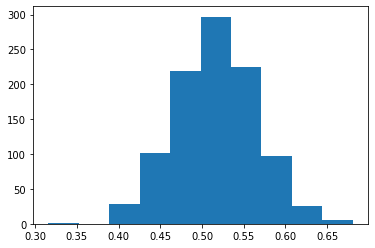

In [ ]:
plt.hist(y)

2    551
0    267
1    182
dtype: int64

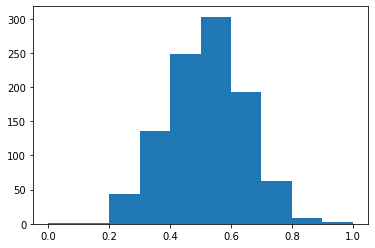

In [ ]:
import pandas as pd
plt.hist(tmp)
pd.value_counts(rates.data.numpy())

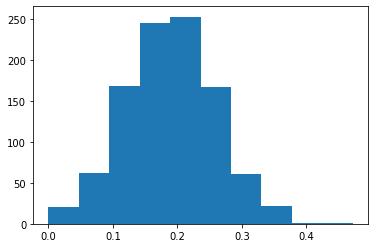

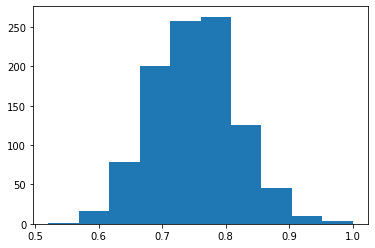

In [ ]:
plt.hist(arr[:,0])
plt.show()
plt.hist(arr[:,1])
plt.show()

         x0        x1  y
0  0.203740  0.729291  2
1  0.148442  0.753201  2
2  0.259359  0.779390  0
3  0.296445  0.718870  0
4  0.204111  0.762857  2


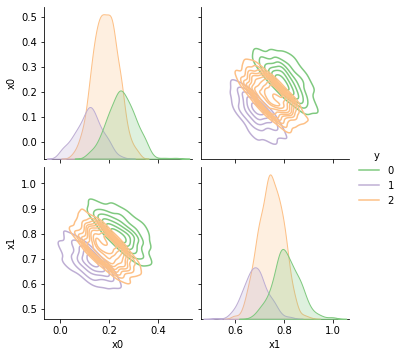

In [ ]:
import seaborn as sbn
import pandas as pd
df = pd.DataFrame({'x0':arr[:, 0], 'x1':arr[:, 1], 'y': rates})
print (df.head())
sbn.pairplot(df, hue='y',  kind="kde", palette = 'Accent')
# g.map_lower(sbn.kdeplot, levels=4, color=".2")

In [ ]:
y_onehot = torch.from_numpy(np.array(pd.get_dummies(df['y']))).float()
y_onehot

tensor([[0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]])

In [ ]:
df['y'].value_counts()

2    551
0    267
1    182
Name: y, dtype: int64

In [ ]:
y_labels = torch.from_numpy(np.array(df['y'])).long()
y_labels

tensor([2, 2, 0, 0, 2, 2, 2, 1, 1, 2, 1, 0, 2, 2, 2, 2, 1, 0, 0, 0, 1, 0, 0, 2,
        1, 2, 2, 2, 2, 1, 0, 1, 2, 0, 2, 2, 2, 2, 0, 2, 0, 1, 2, 2, 1, 1, 2, 0,
        2, 2, 0, 2, 2, 2, 0, 2, 0, 1, 2, 0, 0, 2, 1, 2, 2, 0, 0, 0, 2, 2, 2, 2,
        0, 2, 0, 2, 2, 1, 1, 1, 2, 0, 2, 1, 2, 1, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2,
        0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 1, 1, 1, 0, 2, 2, 0, 2, 0, 1, 2, 0,
        1, 2, 2, 0, 2, 2, 2, 2, 0, 1, 0, 2, 0, 2, 0, 2, 2, 1, 1, 1, 2, 1, 2, 0,
        1, 2, 0, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 1,
        2, 2, 2, 2, 0, 1, 0, 2, 0, 0, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1,
        2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 0, 0, 0, 2, 1, 1, 2, 0, 2, 2, 0, 1, 2,
        2, 1, 2, 2, 2, 2, 1, 0, 1, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 1, 2, 2, 0, 0,
        1, 2, 1, 2, 2, 0, 0, 1, 0, 0, 0, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 0,
        1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 1, 1, 2, 2, 1, 2, 0, 2,
        1, 1, 2, 2, 2, 2, 2, 0, 2, 2, 0,

# 2.  Models

## 2.1 Utils

In [ ]:
def get_mulogvar(x):
    mu, log_var = torch.mean(x), torch.log(torch.var(x))
    return mu, log_var

def log_norm2(x, mu, log_var):
    #similar log_norm2, but generate log_var instead var
    """Compute the log pdf of x,
    under a normal distribution with mean mu and standard deviation std."""
    # return -0.5 * torch.log(2*np.pi*var) -(0.5 * (1/var)* (x-mu)**2)
    return -0.5 * (log_var + np.log(2*np.pi)) -(0.5 * (1/torch.exp(log_var))* (x-mu)**2)

In [ ]:
class Demo_SGD_MCTrick_Optimized(torch.nn.Module):
    #similar Demo_SGD_MCTrick, but generate log_std instead std
    def __init__(self, dim = 1000):
        super(Demo_SGD_MCTrick_Optimized, self).__init__()
        self.dim = dim
        self.phi = torch.nn.Parameter(torch.randn(1), requires_grad=True)
        self.tau = torch.nn.Parameter(torch.randn(1), requires_grad=True)
        self.phi.data.fill_(0) #mean, arbitrarily init
        self.tau.data.fill_(-1.0) #log_std, arbitrarily init
        self.x = self.generate()

    def generate(self):
        eps = scale_minmax(torch.randn(self.dim))-0.5
        x_hat = self.phi + torch.exp(self.tau) * 2 * eps
        return x_hat

    def forward(self):
        self.x = self.generate()
        return self.x

    def get_param(self):
        return {"phi":self.phi.item(), "tau": self.tau.item()}

    def get_approx(self, n_sample=3000):
        return self.x

In [ ]:
class Demo_SGD_InferNet_Optimized(torch.nn.Module):
    #similar Demo_SGD_InferNet, but generate log_std instead std
    def __init__(self, his, dim = 1000):
        super(Demo_SGD_InferNet_Optimized, self).__init__()
        self.his = his
        self.dim = dim
        self.mean_fc = torch.nn.Linear(1, 1)
        self.var_fc = torch.nn.Linear(1, 1)
        self.phi, self.tau = None, None

    def generate(self):
        eps = scale_minmax(torch.randn(self.dim))-0.5
        x_hat = self.phi + torch.exp(self.tau) * 2 * eps
        return x_hat

    def forward(self):
        self.phi = torch.mean(self.mean_fc(self.his))
        self.tau = torch.mean(self.var_fc(self.his))
        self.x = self.generate()
        return self.x

    def get_param(self):
        return {"phi":self.phi.item(), "tau": self.tau.item()}

    def get_approx(self, n_sample=3000):
        return self.x

In [ ]:
# see torch.nn.KLDivLoss
class KLDiv_Loss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean', log_target: bool = False):
        super(KLDiv_Loss, self).__init__(size_average, reduce, reduction)
        self.log_target = log_target

    def forward(self, input, target):
        mu_p, logvar_p = get_mulogvar(target)
        log_p = log_norm2(target, mu_p, logvar_p)
        mu_q, logvar_q = get_mulogvar(target)
        log_q = log_norm2(input, mu_q, logvar_q)
        return torch.nn.functional.kl_div(log_q, log_p, reduction=self.reduction, log_target=self.log_target)

class ELBO_Loss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean', log_target: bool = False):
        super(ELBO_Loss, self).__init__(size_average, reduce, reduction)
        self.log_target = log_target
        # self.KL_Div = KLDiv_Loss(size_average, reduce, reductio, log_target = True)

    def forward(self, input, target):
        mu_p, logvar_p = get_mulogvar(target)
        log_p = log_norm2(target, mu_p, logvar_p)
        mu_q, logvar_q = get_mulogvar(target)
        log_q = log_norm2(input, mu_q, logvar_q)
        kl_div = torch.nn.functional.kl_div(log_q, log_p, reduction=self.reduction, log_target=self.log_target)
        reconstruct_loss = log_norm2(target, mu_q, logvar_q)
        if self.reduction == 'mean':
            reconstruct_loss = torch.mean(log_p)
        else:
            reconstruct_loss = torch.sum(log_p)
        elbo = reconstruct_loss - kl_div
        return -elbo

class Combining_Loss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean', log_target: bool = False):
        super(Combining_Loss, self).__init__(size_average, reduce, reduction)
        self.log_target = log_target

    def forward(self, input, target):
        mu_p, logvar_p = get_mulogvar(target)
        log_p = log_norm2(target, mu_p, logvar_p)
        mu_q, logvar_q = get_mulogvar(target)
        log_q = log_norm2(input, mu_q, logvar_q)

        kl_loss = torch.nn.functional.kl_div(log_q, log_p, reduction=self.reduction, log_target=self.log_target)
        reconstruct_loss = torch.nn.functional.mse_loss(input, target, reduction=self.reduction)

        loss = -(reconstruct_loss - kl_loss)
        return loss

## 2.2 VAE

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.fcmu = torch.nn.Linear(input_dim, latent_dim)
        self.fclv = torch.nn.Linear(input_dim, latent_dim)
        # self.bnmu = torch.nn.BatchNorm1d(latent_dim)
        # self.bnlv = torch.nn.BatchNorm1d(latent_dim)
        self.mu, self.lv = None, None

    def forward(self, inputs):
        self.mu = self.fcmu(inputs)
        self.lv = self.fclv(inputs)
        # self.mu = self.bnmu(self.fcmu(inputs))
        # self.lv = self.bnlv(self.fclv(inputs))
        dist = torch.distributions.LogNormal(self.mu, (0.5 * self.lv).exp())
        return dist

class Decoder(torch.nn.Module):
    def __init__(self,  latent_dim, input_dim):
        super().__init__()
        self.drop = torch.nn.Dropout(0.7)
        self.fcmu = torch.nn.Linear(latent_dim, input_dim)
        self.fclv = torch.nn.Linear(latent_dim, input_dim)
        self.bnmu = torch.nn.BatchNorm1d(input_dim)
        self.bnlv = torch.nn.BatchNorm1d(input_dim)
        self.out = None

    def forward(self, inputs):
        inputs = self.drop(inputs)
        hmu = self.bnmu(self.fcmu(inputs))
        hlv = self.bnlv(self.fclv(inputs))
        self.out = torch.distributions.Normal(hmu, (0.5*hlv).exp()).rsample()
        return self.out

class VAE(torch.nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)
        self.training = True

    def forward(self, inputs):
        posterior = self.encoder(inputs)
        if self.training:
            t = posterior.rsample()
        else:
            t = posterior.mean
        t = t/t.sum(1, keepdim=True)
        outputs = self.decoder(t)
        return posterior, outputs

    def get_param(self):
        return {'mu':self.encoder.mu.mean().data.numpy(), 'logvar':self.encoder.lv.mean().data.numpy()}

    def get_approx(self, n_sample=1000):
        # dist = torch.distributions.LogNormal(self.encoder.mu, (0.5 * self.encoder.lv).exp())
        # t = dist.rsample()
        # t=t/t.sum(1, keepdim=True)
        # outputs = self.decoder(t)
        # return outputs
        return self.decoder.out

In [ ]:
def vae_training(model, loss_fn, obs, epochs=500):
    optim   = torch.optim.Adam(model.parameters(), lr=0.01)
    view_step = epochs/10
    loss_track, param_track = [], []

    for step in range(epochs):
        # Computing Loss
        posterior, outputs = model(obs)
        loss = loss_fn(outputs, obs)
        loss_track.append(loss)
        param_track.append(model.get_param())

        # Tracking
        if (loss < 0) or (step==0) or (step % view_step == view_step-1):
            print ('+ Loss = %.6f' % loss)
            print ('+ Param: ', param_track[-1])
            if (loss < 0):
                print ("----Early stopping----")
                break

        # Optimizing
        optim.zero_grad()
        loss.backward()
        optim.step()
    return loss_track, param_track

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


+ Loss = 50.041882
+ Param:  {'mu': array(0.01521228, dtype=float32), 'logvar': array(-0.11168896, dtype=float32)}
+ Loss = 7.200563
+ Param:  {'mu': array(0.02862699, dtype=float32), 'logvar': array(0.00579816, dtype=float32)}
+ Loss = 3.471183
+ Param:  {'mu': array(0.01242759, dtype=float32), 'logvar': array(-0.01068416, dtype=float32)}
+ Loss = 2.200890
+ Param:  {'mu': array(0.00627419, dtype=float32), 'logvar': array(-0.02113687, dtype=float32)}
+ Loss = 1.305057
+ Param:  {'mu': array(0.00533945, dtype=float32), 'logvar': array(-0.02304161, dtype=float32)}
+ Loss = 0.685693
+ Param:  {'mu': array(0.00428655, dtype=float32), 'logvar': array(-0.02426589, dtype=float32)}
+ Loss = 0.493475
+ Param:  {'mu': array(0.00414825, dtype=float32), 'logvar': array(-0.02523399, dtype=float32)}
+ Loss = 0.211502
+ Param:  {'mu': array(0.00363048, dtype=float32), 'logvar': array(-0.02575426, dtype=float32)}
+ Loss = -0.001879
+ Param:  {'mu': array(0.00354964, dtype=float32), 'logvar': array(-0

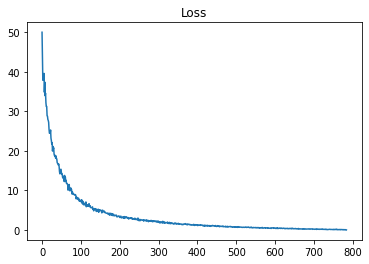

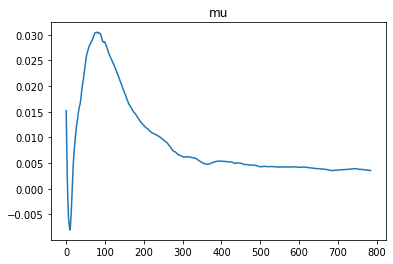

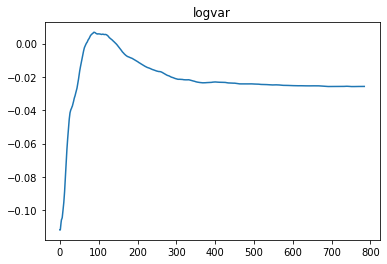

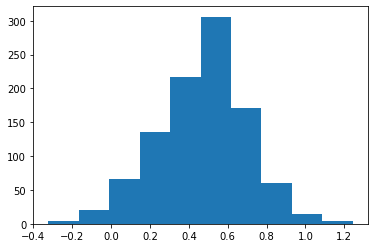

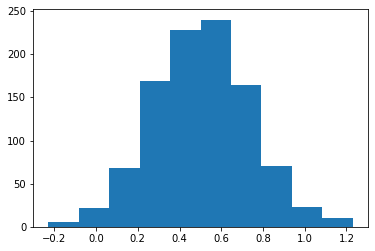

In [ ]:
model = VAE(2, 8)
loss_fn = KLDiv_Loss(reduction='mean')
loss_track, param_track = vae_training(model, loss_fn, arr, 1000)
visualize(loss_track, param_track, model.get_approx().data.numpy())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


+ Loss = 36.392433
+ Param:  {'mu': array(-0.41785985, dtype=float32), 'logvar': array(0.07535176, dtype=float32)}
+ Loss = 6.499838
+ Param:  {'mu': array(-0.46304947, dtype=float32), 'logvar': array(-0.06753211, dtype=float32)}
+ Loss = 2.973241
+ Param:  {'mu': array(-0.44862822, dtype=float32), 'logvar': array(-0.05985998, dtype=float32)}
+ Loss = 1.520311
+ Param:  {'mu': array(-0.45081723, dtype=float32), 'logvar': array(-0.05954816, dtype=float32)}
+ Loss = 0.730407
+ Param:  {'mu': array(-0.45244542, dtype=float32), 'logvar': array(-0.06009466, dtype=float32)}
+ Loss = 0.179160
+ Param:  {'mu': array(-0.45138913, dtype=float32), 'logvar': array(-0.05983971, dtype=float32)}
+ Loss = -0.037813
+ Param:  {'mu': array(-0.45200837, dtype=float32), 'logvar': array(-0.05939791, dtype=float32)}
----Early stopping----


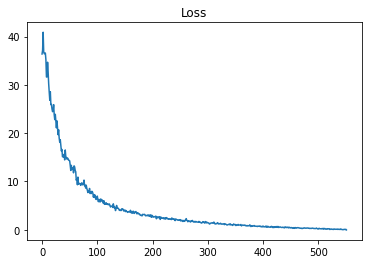

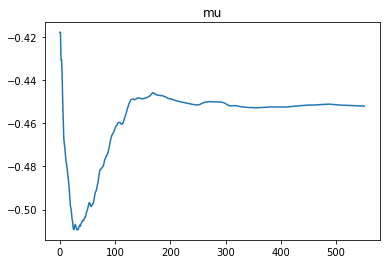

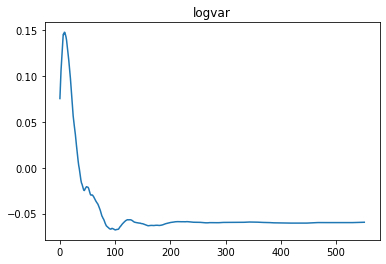

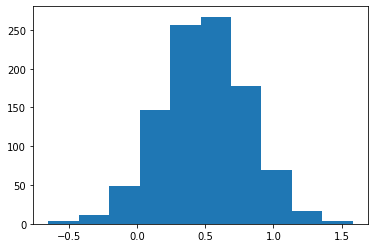

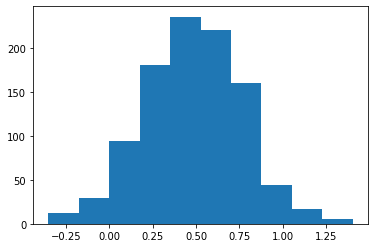

In [ ]:
model = VAE(2, 1)
loss_fn = ELBO_Loss(reduction='mean')
loss_track, param_track = vae_training(model, loss_fn, arr, 1000)
visualize(loss_track, param_track, model.get_approx().data.numpy())

## 2.3 Classify

In [ ]:
def predictiveclassify_vae_training(model, loss_fn, obs, onehot_labels, epochs=500, alpha=0.5):
    optim   = torch.optim.Adam(model.parameters(), lr=0.001)
    view_step = epochs/10
    loss_track, resloss_track, predloss_track, param_track = [], [], [], []

    for step in range(epochs):
        # Computing Loss
        posterior, outputs, pred = model(obs)
        res_loss = loss_fn(outputs, obs)

        pred_label = np.argmax(model.get_approx()[1].data.numpy(), axis=1)
        pred_weight = np.array([np.sum(pred_label==i) for i in range(3)])
        pred_weight = 1.0*pred_weight /len(pred_weight)
        pred_loss = torch.nn.functional.binary_cross_entropy(pred, onehot_labels)#, weight=torch.from_numpy(pred_weight).float())

        loss = res_loss*(1-alpha) + pred_loss*alpha
        loss_track.append(loss)
        resloss_track.append(res_loss)
        predloss_track.append(pred_loss)
        param_track.append(model.get_param())

        # Tracking
        if (loss < 0) or (step==0) or (step % view_step == view_step-1):
            print ('Epoch %d:' % step)
            print ('   +   Total loss: %.6f, reconstruct loss: %.6f, predict loss: %.6f' % (loss, res_loss, pred_loss))
            pred_label = np.argmax(model.get_approx()[1].data.numpy(), axis=1)
            true_label = np.argmax(onehot_labels.data.numpy(), axis=1)
            print ('   +   Mean binary error: ', np.mean(pred_label != true_label))
            print (pd.value_counts(pred_label))
            print ('   +   Param: ', param_track[-1])
            if (loss < 0):
                print ("----Early stopping----")
                break

        # Optimizing
        optim.zero_grad()
        loss.backward()
        optim.step()
    return loss_track, resloss_track, predloss_track, param_track

def visualize_predvae(loss_track, resloss_track, predloss_track, param_track, model):
    visualize(loss_track, param_track, model.get_approx()[0].data.numpy())
    plt.plot(range(len(resloss_track)), resloss_track)
    plt.title('Reconstruction Loss')
    plt.show()
    plt.plot(range(len(predloss_track)), predloss_track)
    plt.title('Prediction Loss')
    plt.show()

### 2.3.1  Predictive Sampling VAE

In [ ]:
class Classifier(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc = torch.nn.Linear(input_dim, output_dim)
        self.out = None

    def forward(self, inputs):
        h = self.fc(inputs)
        self.out = torch.sigmoid(h)
        return self.out

    def get_approx(self):
        return self.out

class PredictiveClassifySampling_VAE(torch.nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)
        self.classifier = Classifier(input_dim, output_dim)
        self.training = True

    def forward(self, inputs):
        posterior = self.encoder(inputs)
        if self.training:
            t = posterior.rsample()
        else:
            t = posterior.mean
        t = t/t.sum(1, keepdim=True)
        outputs = self.decoder(t)
        pred = self.classifier(outputs)
        return posterior, outputs, pred

    def get_param(self):
        return {'mu':self.encoder.mu.mean().data.numpy(), 'logvar':self.encoder.lv.mean().data.numpy()}

    def get_approx(self, n_sample=1000):
        # dist = torch.distributions.LogNormal(self.encoder.mu, (0.5 * self.encoder.lv).exp())
        # t = dist.rsample()
        # t=t/t.sum(1, keepdim=True)
        # outputs = self.decoder(t)
        # return outputs
        return self.decoder.out, self.classifier.get_approx()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch 0:
   +   Total loss: 21.965435, reconstruct loss: 43.140987, predict loss: 0.789883
   +   Mean binary error:  0.68
2    489
0    382
1    129
dtype: int64
   +   Param:  {'mu': array(-0.39722547, dtype=float32), 'logvar': array(-0.30446258, dtype=float32)}
Epoch 9:
   +   Total loss: 18.906874, reconstruct loss: 37.053871, predict loss: 0.759876
   +   Mean binary error:  0.681
2    536
0    362
1    102
dtype: int64
   +   Param:  {'mu': array(-0.4013036, dtype=float32), 'logvar': array(-0.31323525, dtype=float32)}
Epoch 19:
   +   Total loss: 17.827213, reconstruct loss: 34.903072, predict loss: 0.751355
   +   Mean binary error:  0.671
2    521
0    350
1    129
dtype: int64
   +   Param:  {'mu': array(-0.39778313, dtype=float32), 'logvar': array(-0.31453365, dtype=float32)}
Epoch 29:
   +   Total loss: 18.314955, reconstruct loss: 35.855457, predict loss: 0.774453
   +   Mean binary error:  0.692
2    510
0    368
1    122
dtype: int64
   +   Param:  {'mu': array(-0.3949671

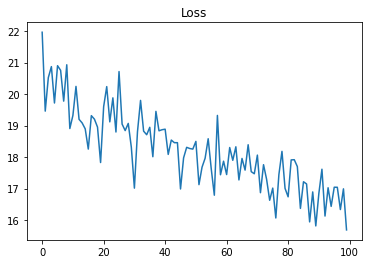

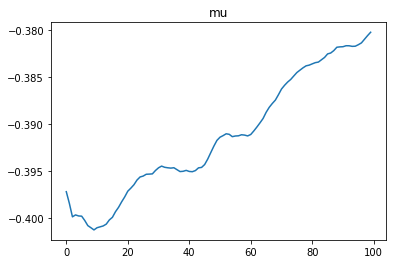

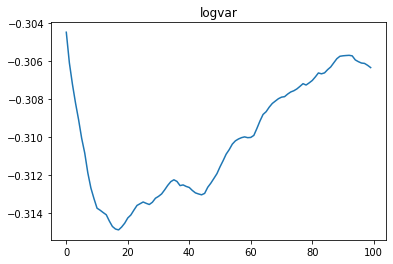

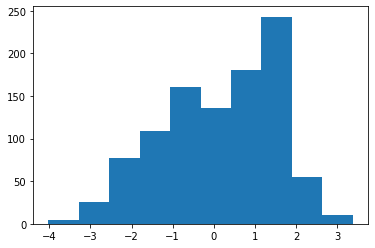

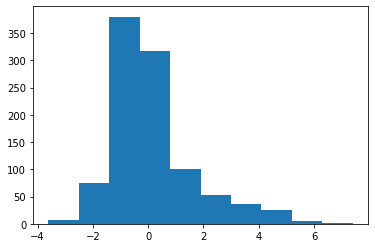

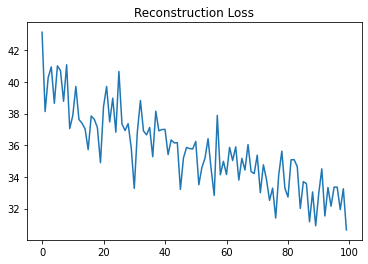

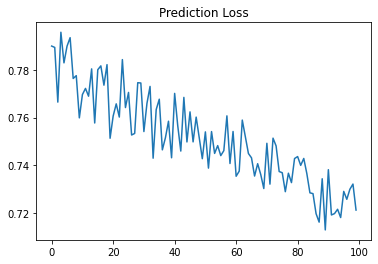

In [ ]:
# del model2
model2 = PredictiveClassifySampling_VAE(2, 1, 3)
loss_fn = KLDiv_Loss(reduction='mean')
loss_track, resloss_track, predloss_track, param_track = predictiveclassify_vae_training(model2, loss_fn, arr, y_onehot, 100, alpha=0.5)
visualize_predvae(loss_track, resloss_track, predloss_track, param_track, model2)

### 2.3.3 Pretrained Classifier with VAE

In [ ]:
class PretrainedClassifier_VAE(torch.nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim, classifier):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)
        self.classifier = classifier
        self.training = True

    def forward(self, inputs):
        posterior = self.encoder(inputs)
        if self.training:
            t = posterior.rsample()
        else:
            t = posterior.mean
        t = t/t.sum(1, keepdim=True)
        outputs = self.decoder(t)
        pred = self.classifier(outputs)
        return posterior, outputs, pred

    def get_param(self):
        return {'mu':self.encoder.mu.mean().data.numpy(), 'logvar':self.encoder.lv.mean().data.numpy()}

    def get_approx(self, n_sample=1000):
        # dist = torch.distributions.LogNormal(self.encoder.mu, (0.5 * self.encoder.lv).exp())
        # t = dist.rsample()
        # t=t/t.sum(1, keepdim=True)
        # outputs = self.decoder(t)
        # return outputs
        return self.decoder.out, self.classifier.get_approx()

In [ ]:
class Classifier(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc = torch.nn.Linear(input_dim, output_dim)
        self.softmax = torch.nn.Softmax()
        self.out = None

    def forward(self, inputs):
        h = self.fc(inputs)
        self.out = self.softmax(torch.sigmoid(h))
        return self.out

    def get_approx(self):
        return self.out

def classifier_training(model, x, y, epochs):
    optim   = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()
    view_step = epochs/10
    loss_track = []

    for step in range(epochs):
        # Computing Loss
        pred = model(x)

        pred_label = np.argmax(model.get_approx().data.numpy(), axis=1)
        pred_weight = np.array([np.sum(pred_label==i) for i in range(3)])
        pred_weight = 1.0*pred_weight /len(pred_weight)
        loss = criterion(pred, y)#, weight=torch.from_numpy(pred_weight).float())
        # loss =
        loss_track.append(loss)
        # param_track.append(model.get_param())

        # Tracking
        if (loss < 0) or (step==0) or (step % view_step == view_step-1):
            print ('Epoch %d:' % step)
            pred_label = np.argmax(model.get_approx().data.numpy(), axis=1)
            # true_label = np.argmax(onehot_labels.data.numpy(), axis=1)
            print ('   +   Mean binary error: ', np.mean(pred_label != y))
            print (pd.value_counts(pred_label))
            if (loss < 0):
                print ("----Early stopping----")
                break

        # Optimizing
        optim.zero_grad()
        loss.backward()
        optim.step()
    return loss_track

In [ ]:
classifier = Classifier(2, 3)
loss_track = classifier_training(classifier, arr, y_labels, 100)

Epoch 0:
   +   Mean binary error:  1.0
2    1000
dtype: int64
Epoch 9:
   +   Mean binary error:  1.0
2    1000
dtype: int64
Epoch 19:
   +   Mean binary error:  1.0
2    1000
dtype: int64
Epoch 29:
   +   Mean binary error:  1.0
2    1000
dtype: int64
Epoch 39:
   +   Mean binary error:  1.0
2    1000
dtype: int64
Epoch 49:
   +   Mean binary error:  1.0
2    1000
dtype: int64
Epoch 59:
   +   Mean binary error:  1.0
2    1000
dtype: int64
Epoch 69:
   +   Mean binary error:  1.0
2    1000
dtype: int64
Epoch 79:
   +   Mean binary error:  1.0
2    1000
dtype: int64
Epoch 89:
   +   Mean binary error:  1.0
2    1000
dtype: int64
Epoch 99:
   +   Mean binary error:  1.0
2    1000
dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


## 2.4 Regression

### Predictive VAE

In [ ]:
class Regression_Sampling(torch.nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.fcmu = torch.nn.Linear(latent_dim, output_dim)
        self.fclv = torch.nn.Linear(latent_dim, output_dim)
        self.out = None

    def forward(self, latent_mu, latent_var):
        # latent_mu = self.drop(latent_mu)
        # latent_var = self.drop(latent_var)
        hmu = self.fcmu(latent_mu)
        hlv = self.fclv(latent_var)
        sampling = torch.distributions.Normal(hmu, (0.5*hlv).exp()).rsample()
        self.out = sampling #torch.sigmoid(sampling)
        return self.out

class PredictiveRegressionSampling_VAE(torch.nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)
        self.regressor = Regression_Sampling(latent_dim, output_dim)
        self.training = True

    def forward(self, inputs):
        posterior = self.encoder(inputs)
        pred = self.regressor(self.encoder.mu, self.encoder.lv)
        if self.training:
            t = posterior.rsample()
        else:
            t = posterior.mean
        t = t/t.sum(1, keepdim=True)
        outputs = self.decoder(t)
        return posterior, outputs, pred

    def get_param(self):
        return {'mu':self.encoder.mu.mean().data.numpy(), 'logvar':self.encoder.lv.mean().data.numpy()}

    def get_approx(self, n_sample=1000):
        # dist = torch.distributions.LogNormal(self.encoder.mu, (0.5 * self.encoder.lv).exp())
        # t = dist.rsample()
        # t=t/t.sum(1, keepdim=True)
        # outputs = self.decoder(t)
        # return outputs
        return self.decoder.out, self.regressor.out

In [ ]:
def predictiveregression_vae_training(model, loss_fn, obs, target, epochs=500, alpha=0.5):
    optim   = torch.optim.Adam(model.parameters(), lr=0.001)
    view_step = epochs/10
    loss_track, resloss_track, predloss_track, param_track = [], [], [], []

    for step in range(epochs):
        # Computing Loss
        posterior, outputs, pred = model(obs)

        res_loss = loss_fn(outputs, obs)
        pred_loss = torch.nn.functional.mse_loss(pred, target)
        # res_loss.requires_grad=True
        # pred_loss.requires_grad=True

        loss = res_loss*(1-alpha) + pred_loss*alpha
        loss_track.append(loss)
        resloss_track.append(res_loss)
        predloss_track.append(pred_loss)
        param_track.append(model.get_param())

        # Tracking
        if (loss < 0) or (step==0) or (step % view_step == view_step-1):
            print ('Epoch %d:' % step)
            print ('   +   Total loss: %.6f, reconstruct loss: %.6f, predict loss: %.6f' % (loss, res_loss, pred_loss))
            print ('   +   Param: ', param_track[-1])
            if (loss < 0):
                print ("----Early stopping----")
                break

        # Optimizing
        optim.zero_grad()
        loss.backward()
        optim.step()
    return loss_track, resloss_track, predloss_track, param_track

def visualize_predvae(loss_track, resloss_track, predloss_track, param_track, model):
    visualize(loss_track, param_track, model.get_approx()[0].data.numpy())
    plt.plot(range(len(resloss_track)), resloss_track)
    plt.title('Reconstruction Loss')
    plt.show()
    plt.plot(range(len(predloss_track)), predloss_track)
    plt.title('Prediction Loss')
    plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  # This is added back by InteractiveShellApp.init_path()


Epoch 0:
   +   Total loss: 15.284148, reconstruct loss: 16.045771, predict loss: 0.813324
   +   Param:  {'mu': array(0.3682133, dtype=float32), 'logvar': array(-0.45449874, dtype=float32)}
Epoch 299:
   +   Total loss: 5.800649, reconstruct loss: 6.094578, predict loss: 0.215986
   +   Param:  {'mu': array(0.83793664, dtype=float32), 'logvar': array(-0.97284997, dtype=float32)}
Epoch 599:
   +   Total loss: 3.220919, reconstruct loss: 3.385349, predict loss: 0.096753
   +   Param:  {'mu': array(0.9809597, dtype=float32), 'logvar': array(-1.3469527, dtype=float32)}
Epoch 899:
   +   Total loss: 2.592043, reconstruct loss: 2.725678, predict loss: 0.052983
   +   Param:  {'mu': array(0.9846412, dtype=float32), 'logvar': array(-1.6120313, dtype=float32)}
Epoch 1199:
   +   Total loss: 2.173368, reconstruct loss: 2.285966, predict loss: 0.034007
   +   Param:  {'mu': array(0.9908178, dtype=float32), 'logvar': array(-1.8084116, dtype=float32)}
Epoch 1499:
   +   Total loss: 1.604707, recon

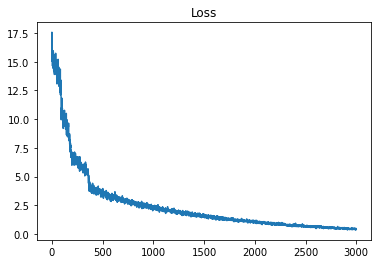

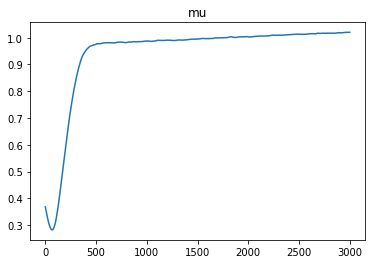

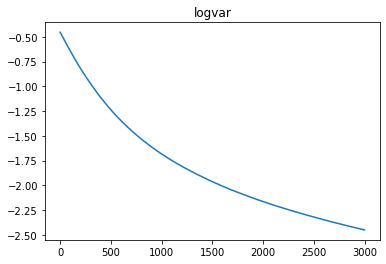

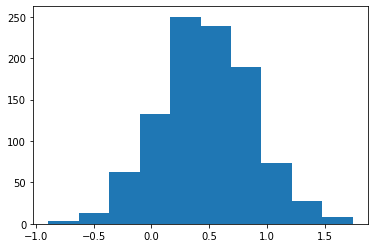

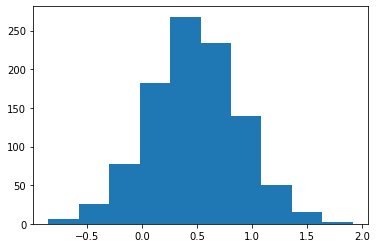

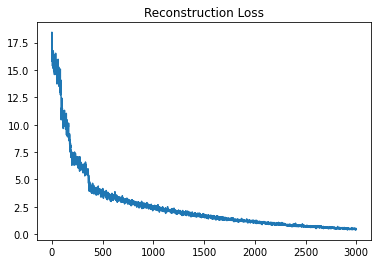

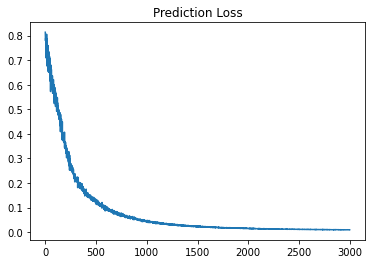

In [ ]:
# del model4
model4 = PredictiveRegressionSampling_VAE(2, 1, 1)
loss_fn = KLDiv_Loss(reduction='mean')
loss_track, resloss_track, predloss_track, param_track = predictiveregression_vae_training(model4, loss_fn, arr, y, 3000, alpha=0.05)
visualize_predvae(loss_track, resloss_track, predloss_track, param_track, model4)

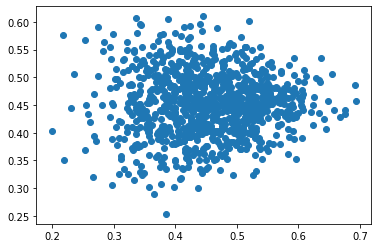

In [ ]:
plt.scatter(y.data.numpy(), model4.regressor.out.data.numpy())

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


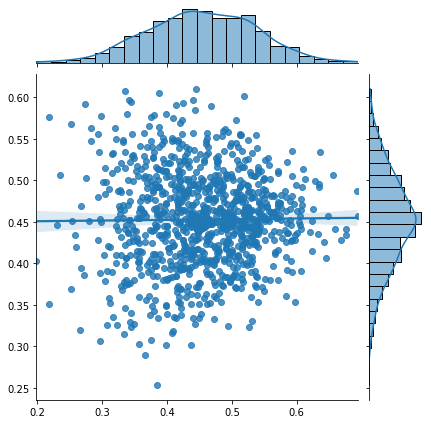

In [ ]:
import seaborn as sns
sns.jointplot(y.data.numpy().reshape(-1), model4.regressor.out.data.numpy().reshape(-1), kind='reg')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  # This is added back by InteractiveShellApp.init_path()


Epoch 0:
   +   Total loss: 16.941877, reconstruct loss: 17.799290, predict loss: 0.651065
   +   Param:  {'mu': array(-0.08243112, dtype=float32), 'logvar': array(0.48627815, dtype=float32)}
Epoch 299:
   +   Total loss: 5.513959, reconstruct loss: 5.784193, predict loss: 0.379513
   +   Param:  {'mu': array(0.25992134, dtype=float32), 'logvar': array(0.64439714, dtype=float32)}
Epoch 599:
   +   Total loss: 3.039700, reconstruct loss: 3.192084, predict loss: 0.144415
   +   Param:  {'mu': array(0.27285495, dtype=float32), 'logvar': array(1.5354364, dtype=float32)}
Epoch 899:
   +   Total loss: 2.196060, reconstruct loss: 2.308292, predict loss: 0.063642
   +   Param:  {'mu': array(0.27950534, dtype=float32), 'logvar': array(2.0950966, dtype=float32)}
Epoch 1199:
   +   Total loss: 1.574178, reconstruct loss: 1.655112, predict loss: 0.036422
   +   Param:  {'mu': array(0.2862858, dtype=float32), 'logvar': array(2.4580052, dtype=float32)}
Epoch 1499:
   +   Total loss: 1.327331, recons

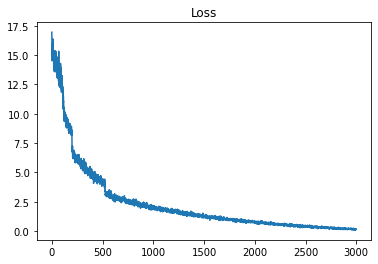

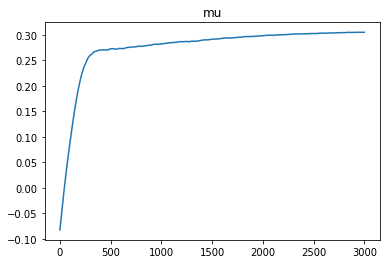

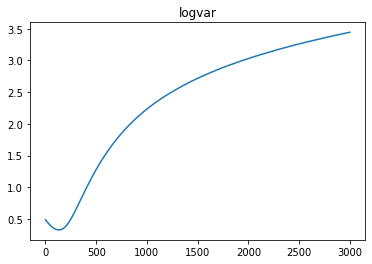

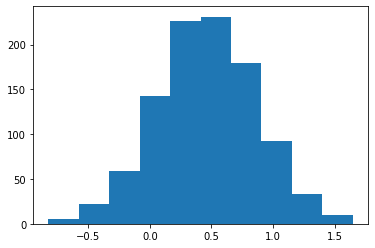

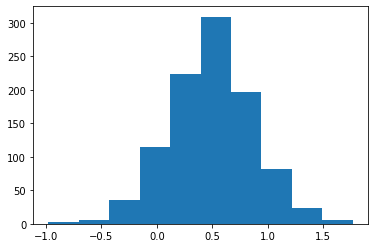

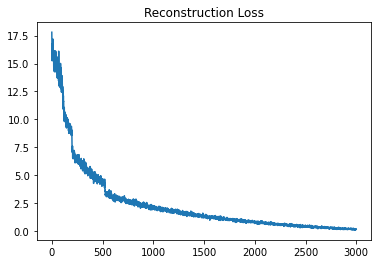

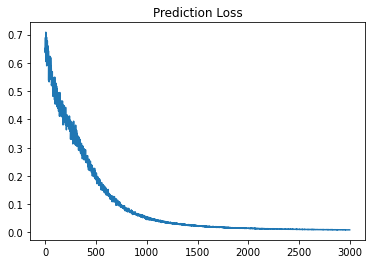

In [ ]:
# del model4 #no-sigmoid
model4 = PredictiveRegressionSampling_VAE(2, 1, 1)
loss_fn = ELBO_Loss(reduction='mean')
loss_track, resloss_track, predloss_track, param_track = predictiveregression_vae_training(model4, loss_fn, arr, y, 3000, alpha=0.05)
visualize_predvae(loss_track, resloss_track, predloss_track, param_track, model4)

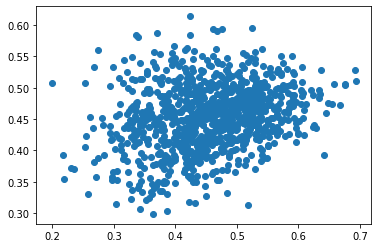

In [ ]:
plt.scatter(y.data.numpy(), model4.regressor.out.data.numpy())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  # This is added back by InteractiveShellApp.init_path()


Epoch 0:
   +   Total loss: 14.932260, reconstruct loss: 15.716078, predict loss: 0.039705
   +   Param:  {'mu': array(-0.7271703, dtype=float32), 'logvar': array(-0.29063118, dtype=float32)}
Epoch 299:
   +   Total loss: 7.212761, reconstruct loss: 7.591167, predict loss: 0.023060
   +   Param:  {'mu': array(-1.3332126, dtype=float32), 'logvar': array(0.20138144, dtype=float32)}
Epoch 599:
   +   Total loss: 2.763062, reconstruct loss: 2.907725, predict loss: 0.014462
   +   Param:  {'mu': array(-1.3502915, dtype=float32), 'logvar': array(0.9535824, dtype=float32)}
Epoch 899:
   +   Total loss: 2.212907, reconstruct loss: 2.328885, predict loss: 0.009332
   +   Param:  {'mu': array(-1.3278772, dtype=float32), 'logvar': array(1.5201423, dtype=float32)}
Epoch 1199:
   +   Total loss: 1.760064, reconstruct loss: 1.852273, predict loss: 0.008101
   +   Param:  {'mu': array(-1.3166322, dtype=float32), 'logvar': array(1.8710842, dtype=float32)}
Epoch 1499:
   +   Total loss: 1.179598, recon

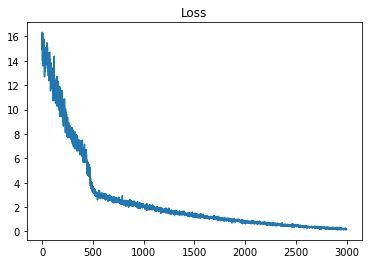

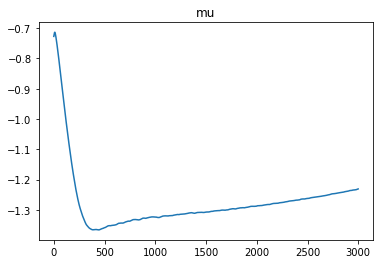

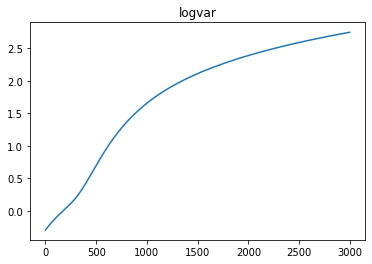

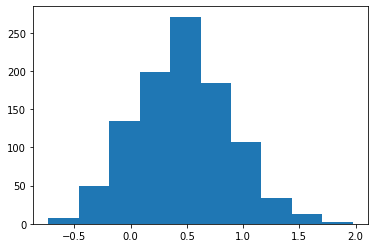

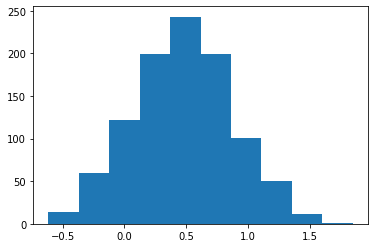

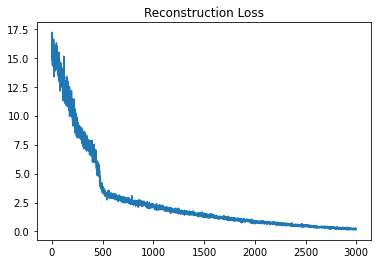

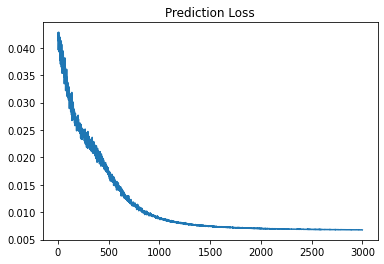

In [ ]:
# del model4 #with sigmoid
model4 = PredictiveRegressionSampling_VAE(2, 1, 1)
loss_fn = ELBO_Loss(reduction='mean')
loss_track, resloss_track, predloss_track, param_track = predictiveregression_vae_training(model4, loss_fn, arr, y, 3000, alpha=0.05)
visualize_predvae(loss_track, resloss_track, predloss_track, param_track, model4)

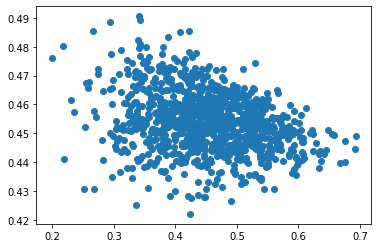

In [ ]:
plt.scatter(y.data.numpy(), model4.regressor.out.data.numpy())

### pretrained-regressor VAE

In [ ]:
class Regressor(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc = torch.nn.Linear(input_dim, output_dim)
        self.out = None

    def forward(self, inputs):
        h = self.fc(inputs)
        self.out = torch.sigmoid(h)
        return self.out

    def get_approx(self):
        return self.out

def regressor_training(model, x, y, epochs):
    optim   = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()
    view_step = epochs/10
    loss_track = []

    for step in range(epochs):
        # Computing Loss
        pred = model(x)
        loss = criterion(pred, y)#, weight=torch.from_numpy(pred_weight).float())
        loss_track.append(loss)

        # Tracking
        if (loss < 0) or (step==0) or (step % view_step == view_step-1):
            print ('Epoch %d: Loss = %.6f' % (step, loss))
            if (loss < 0):
                print ("----Early stopping----")
                break

        # Optimizing
        optim.zero_grad()
        loss.backward()
        optim.step()
    return loss_track

# Clean code

## Utils

In [ ]:
def get_mulogvar(x):
    mu, log_var = torch.mean(x), torch.log(torch.var(x))
    return mu, log_var

def log_norm2(x, mu, log_var):
    #similar log_norm2, but generate log_var instead var
    """Compute the log pdf of x,
    under a normal distribution with mean mu and standard deviation std."""
    # return -0.5 * torch.log(2*np.pi*var) -(0.5 * (1/var)* (x-mu)**2)
    return -0.5 * (log_var + np.log(2*np.pi)) -(0.5 * (1/torch.exp(log_var))* (x-mu)**2)

In [ ]:
# see torch.nn.KLDivLoss
class KLDiv_Loss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean', log_target: bool = False):
        super(KLDiv_Loss, self).__init__(size_average, reduce, reduction)
        self.log_target = log_target

    def forward(self, input, target):
        mu_p, logvar_p = get_mulogvar(target)
        log_p = log_norm2(target, mu_p, logvar_p)
        mu_q, logvar_q = get_mulogvar(target)
        log_q = log_norm2(input, mu_q, logvar_q)
        return torch.nn.functional.kl_div(log_q, log_p, reduction=self.reduction, log_target=self.log_target)

class ELBO_Loss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean', log_target: bool = False):
        super(ELBO_Loss, self).__init__(size_average, reduce, reduction)
        self.log_target = log_target
        # self.KL_Div = KLDiv_Loss(size_average, reduce, reductio, log_target = True)

    def forward(self, input, target):
        mu_p, logvar_p = get_mulogvar(target)
        log_p = log_norm2(target, mu_p, logvar_p)
        mu_q, logvar_q = get_mulogvar(target)
        log_q = log_norm2(input, mu_q, logvar_q)
        kl_div = torch.nn.functional.kl_div(log_q, log_p, reduction=self.reduction, log_target=self.log_target)
        reconstruct_loss = log_norm2(target, mu_q, logvar_q)
        if self.reduction == 'mean':
            reconstruct_loss = torch.mean(log_p)
        else:
            reconstruct_loss = torch.sum(log_p)
        elbo = reconstruct_loss - kl_div
        return -elbo

class Combining_Loss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean', log_target: bool = False):
        super(Combining_Loss, self).__init__(size_average, reduce, reduction)
        self.log_target = log_target

    def forward(self, input, target):
        mu_p, logvar_p = get_mulogvar(target)
        log_p = log_norm2(target, mu_p, logvar_p)
        mu_q, logvar_q = get_mulogvar(target)
        log_q = log_norm2(input, mu_q, logvar_q)

        kl_loss = torch.nn.functional.kl_div(log_q, log_p, reduction=self.reduction, log_target=self.log_target)
        reconstruct_loss = torch.nn.functional.mse_loss(input, target, reduction=self.reduction)

        loss = -(reconstruct_loss - kl_loss)
        return loss

## Based model

In [ ]:
class Predictor(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc = torch.nn.Linear(input_dim, output_dim)
        self.out = None

    def forward(self, inputs):
        self.out = self.fc(inputs)
        return self.out

    def get_approx(self):
        return self.out

    def get_param(self):
        params = {}
        for i in range(len(self.fc.weight)):
            params['w_%d' % i] = self.fc.weight[i]
        return params

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.fcmu = torch.nn.Linear(input_dim, latent_dim)
        self.fclv = torch.nn.Linear(input_dim, latent_dim)
        # self.bnmu = torch.nn.BatchNorm1d(latent_dim)
        # self.bnlv = torch.nn.BatchNorm1d(latent_dim)
        self.mu, self.lv = None, None

    def forward(self, inputs):
        self.mu = self.fcmu(inputs)
        self.lv = self.fclv(inputs)
        # self.mu = self.bnmu(self.fcmu(inputs))
        # self.lv = self.bnlv(self.fclv(inputs))
        dist = torch.distributions.LogNormal(self.mu, (0.5 * self.lv).exp())
        return dist

class Decoder(torch.nn.Module):
    def __init__(self,  latent_dim, input_dim):
        super().__init__()
        self.drop = torch.nn.Dropout(0.7)
        self.fcmu = torch.nn.Linear(latent_dim, input_dim)
        self.fclv = torch.nn.Linear(latent_dim, input_dim)
        self.bnmu = torch.nn.BatchNorm1d(input_dim)
        self.bnlv = torch.nn.BatchNorm1d(input_dim)
        self.out = None

    def forward(self, inputs):
        inputs = self.drop(inputs)
        hmu = self.bnmu(self.fcmu(inputs))
        hlv = self.bnlv(self.fclv(inputs))
        self.out = torch.distributions.Normal(hmu, (0.5*hlv).exp()).rsample()
        return self.out

## Training functions

In [ ]:
def vae_training(model, loss_fn, obs, epochs=500):
    optim   = torch.optim.Adam(model.parameters(), lr=0.001)
    view_step = epochs/10
    loss_track, param_track = [], []

    for step in range(epochs):
        # Computing Loss
        posterior, outputs = model(obs)
        loss = loss_fn(outputs, obs)
        loss_track.append(loss)
        param_track.append(model.get_param())

        # Tracking
        if (loss < 0) or (step==0) or (step % view_step == view_step-1):
            print ('+ Loss = %.6f' % loss)
            print ('+ Param: ', param_track[-1])
            if (loss < 0):
                print ("----Early stopping----")
                break

        # Optimizing
        optim.zero_grad()
        loss.backward()
        optim.step()
    return loss_track, param_track

def predictivevae_training(model, resloss_fn, predloss_fn, obs, target, epochs=500, predloss_weight=0.5):
    optim   = torch.optim.Adam(model.parameters(), lr=0.01)
    view_step = epochs/10
    loss_track, param_track = [], []

    for step in range(epochs):
        # Computing Loss
        posterior, outputs, pred = model(obs)
        res_loss = resloss_fn(outputs, obs)
        pred_loss = predloss_fn(pred, target)
        loss = (1-predloss_weight)*res_loss + predloss_weight*pred_loss
        loss_track.append(loss)
        param_track.append(model.get_param())

        # Tracking
        if (loss < 0) or (step==0) or (step % view_step == view_step-1):
            print ('+ Loss = %.6f' % loss)
            print ('      Reconstruction Loss = %.6f, Prediction Loss = %.6f' % (res_loss, pred_loss))
            print ('+ Param: ', param_track[-1])
            if (loss < 0):
                print ("----Early stopping----")
                break

        # Optimizing
        optim.zero_grad()
        loss.backward()
        optim.step()
    return loss_track, param_track

def predictor_training(model, loss_fn, x, y, epochs=500):
    optim   = torch.optim.Adam(model.parameters(), lr=0.01)
    view_step = epochs/10
    loss_track, param_track = [], []

    for step in range(epochs):
        # Computing Loss
        outputs = model(x).squeeze()
        loss = loss_fn(outputs, y)
        loss_track.append(loss)
        param_track.append(model.get_param())

        # Tracking
        if (loss < 0) or (step==0) or (step % view_step == view_step-1):
            print ('+ Loss = %.6f' % loss)
            print ('+ Param: ', param_track[-1])
            if (loss < 0):
                print ("----Early stopping----")
                break

        # Optimizing
        optim.zero_grad()
        loss.backward()
        optim.step()
    return loss_track, param_track

## VAE

In [ ]:
class VAE(torch.nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)
        self.training = True

    def forward(self, inputs):
        posterior = self.encoder(inputs)
        if self.training:
            t = posterior.rsample()
        else:
            t = posterior.mean
        t = t/t.sum(1, keepdim=True)
        outputs = self.decoder(t)
        return posterior, outputs

    def get_param(self):
        return {'mu':self.encoder.mu.mean().data.numpy(), 'logvar':self.encoder.lv.mean().data.numpy()}

    def get_approx(self, n_sample=1000):
        return self.decoder.out

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


+ Loss = 38.140354
+ Param:  {'mu': array(-0.18524913, dtype=float32), 'logvar': array(-0.0575888, dtype=float32)}
+ Loss = 29.289503
+ Param:  {'mu': array(-0.17378403, dtype=float32), 'logvar': array(-0.05331933, dtype=float32)}
+ Loss = 23.215961
+ Param:  {'mu': array(-0.1692182, dtype=float32), 'logvar': array(-0.05300662, dtype=float32)}
+ Loss = 19.705122
+ Param:  {'mu': array(-0.16555285, dtype=float32), 'logvar': array(-0.04933555, dtype=float32)}
+ Loss = 16.047670
+ Param:  {'mu': array(-0.16457069, dtype=float32), 'logvar': array(-0.04924784, dtype=float32)}
+ Loss = 14.046302
+ Param:  {'mu': array(-0.16409037, dtype=float32), 'logvar': array(-0.04548389, dtype=float32)}
+ Loss = 12.481638
+ Param:  {'mu': array(-0.16281125, dtype=float32), 'logvar': array(-0.04311929, dtype=float32)}
+ Loss = 10.049573
+ Param:  {'mu': array(-0.16156183, dtype=float32), 'logvar': array(-0.04166736, dtype=float32)}
+ Loss = 9.412357
+ Param:  {'mu': array(-0.16016531, dtype=float32), 'log

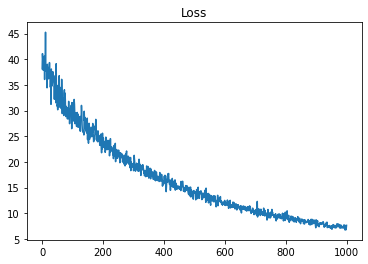

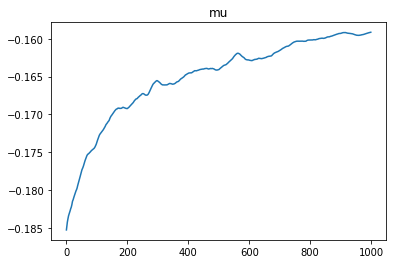

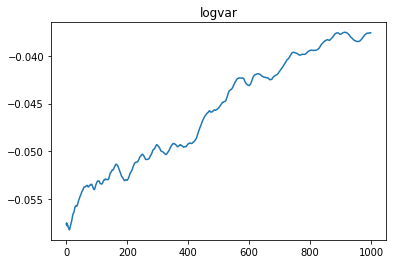

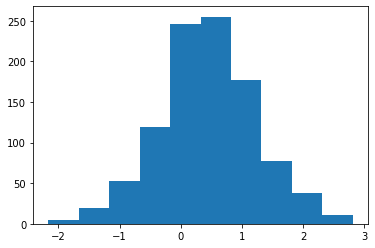

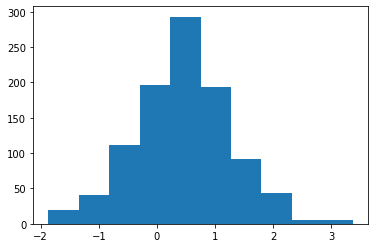

In [ ]:
model = VAE(2, 8)
loss_fn = KLDiv_Loss(reduction='mean')
loss_track, param_track = vae_training(model, loss_fn, arr, 1000)
visualize(loss_track, param_track, model.get_approx().data.numpy())

## Predictive VAE

In [ ]:
class Predictive_VAE(torch.nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)
        self.predictor = Predictor(input_dim, output_dim)
        self.training = True

    def forward(self, inputs):
        posterior = self.encoder(inputs)
        if self.training:
            t = posterior.rsample()
        else:
            t = posterior.mean
        t = t/t.sum(1, keepdim=True)
        outputs = self.decoder(t)
        pred = self.predictor(outputs)
        return posterior, outputs, pred

    def get_param(self):
        return {'mu':self.encoder.mu.mean().data.numpy(), 'logvar':self.encoder.lv.mean().data.numpy()}

    def get_approx(self, n_sample=1000):
        # dist = torch.distributions.LogNormal(self.encoder.mu, (0.5 * self.encoder.lv).exp())
        # t = dist.rsample()
        # t=t/t.sum(1, keepdim=True)
        # outputs = self.decoder(t)
        # return outputs
        return self.decoder.out, self.predictor.get_approx()

In [ ]:
def predictivevae_training(model, resloss_fn, predloss_fn, obs, target, epochs=500, predloss_weight=0.5):
    optim   = torch.optim.Adam(model.parameters(), lr=0.01)
    view_step = epochs/10
    loss_track, param_track = [], []

    for step in range(epochs):
        # Computing Loss
        posterior, outputs, pred = model(obs)
        res_loss = resloss_fn(outputs, obs)
        pred_loss = predloss_fn(pred, target)
        loss = (1-predloss_weight)*res_loss + predloss_weight*pred_loss
        loss_track.append(loss)
        param_track.append(model.get_param())

        # Tracking
        if (loss < 0) or (step==0) or (step % view_step == view_step-1):
            print ('+ Loss = %.6f' % loss)
            print ('      Reconstruction Loss = %.6f, Prediction Loss = %.6f' % (res_loss, pred_loss))
            print ('+ Param: ', param_track[-1])
            if (loss < 0):
                print ("----Early stopping----")
                break

        # Optimizing
        optim.zero_grad()
        loss.backward()
        optim.step()
    return loss_track, param_track

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


+ Loss = 437040.906250
      Reconstruction Loss = 37.666931, Prediction Loss = 1456715.000000
+ Param:  {'mu': array(0.07022319, dtype=float32), 'logvar': array(-0.1756535, dtype=float32)}
+ Loss = 197648.000000
      Reconstruction Loss = 28.350163, Prediction Loss = 658760.500000
+ Param:  {'mu': array(0.11225068, dtype=float32), 'logvar': array(-0.13151376, dtype=float32)}
+ Loss = 99600.914062
      Reconstruction Loss = 24.043472, Prediction Loss = 331946.937500
+ Param:  {'mu': array(0.11845033, dtype=float32), 'logvar': array(-0.11852967, dtype=float32)}
+ Loss = 48928.921875
      Reconstruction Loss = 21.546177, Prediction Loss = 163046.125000
+ Param:  {'mu': array(0.11989165, dtype=float32), 'logvar': array(-0.11011015, dtype=float32)}
+ Loss = 30050.535156
      Reconstruction Loss = 18.964819, Prediction Loss = 100124.195312
+ Param:  {'mu': array(0.12397724, dtype=float32), 'logvar': array(-0.10167331, dtype=float32)}
+ Loss = 18014.933594
      Reconstruction Loss = 18.

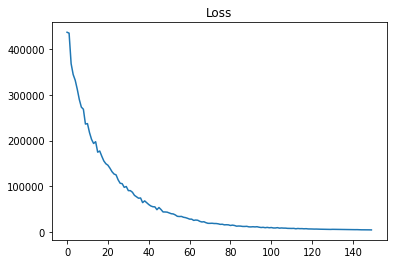

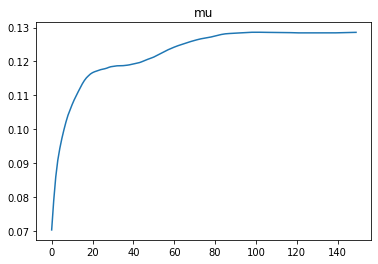

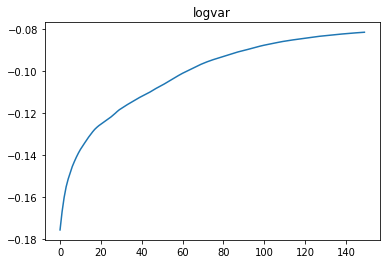

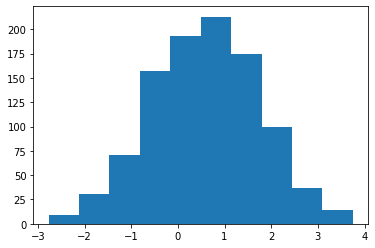

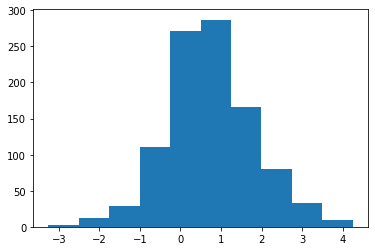

In [ ]:
model = Predictive_VAE(2, 8, 1)
resloss_fn = KLDiv_Loss(reduction='mean')
predloss_fn = torch.nn.MSELoss(reduction='sum')
loss_track, param_track = predictivevae_training(model, resloss_fn, predloss_fn, arr, y, 150, predloss_weight=0.3)
visualize(loss_track, param_track, model.get_approx()[0].data.numpy())

(array([  2.,  15.,  33., 130., 249., 252., 187.,  86.,  40.,   6.]),
 array([0.20571   , 0.24848555, 0.2912611 , 0.33403665, 0.37681222,
        0.41958776, 0.4623633 , 0.5051389 , 0.54791445, 0.59068996,
        0.6334655 ], dtype=float32),
 <a list of 10 Patch objects>)

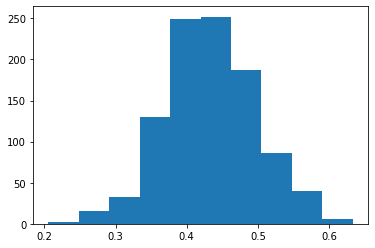

In [ ]:
plt.hist(model.get_approx()[1].data.numpy().reshape(-1, ))

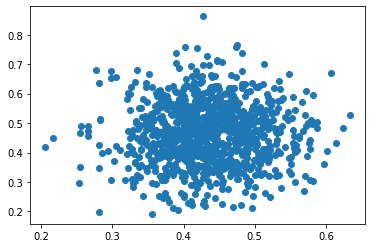

In [ ]:
plt.scatter(model.predictor.get_approx().data.numpy(), y.data.numpy())

## Pretrained-Predictor VAE

In [ ]:
class TrainedPred_VAE(torch.nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim, predictor):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)
        self.predictor = predictor
        self.training = True
        self.res_out, self.pred_out = None, None

    def forward(self, inputs):
        posterior = self.encoder(inputs)
        if self.training:
            t = posterior.rsample()
        else:
            t = posterior.mean
        t = t/t.sum(1, keepdim=True)
        outputs = self.decoder(t)
        pred = self.predictor(outputs)
        self.res_out = outputs
        self.pred_out = pred
        return posterior, outputs, pred

    def get_param(self):
        return {'mu':self.encoder.mu.mean().data.numpy(), 'logvar':self.encoder.lv.mean().data.numpy()}

    def get_approx(self, n_sample=1000):
        # dist = torch.distributions.LogNormal(self.encoder.mu, (0.5 * self.encoder.lv).exp())
        # t = dist.rsample()
        # t=t/t.sum(1, keepdim=True)
        # outputs = self.decoder(t)
        # return outputs
        return self.res_out, self.pred_out

+ Loss = 1949.591064
+ Param:  {'w_0': tensor([-0.4873, -0.2232], grad_fn=<SelectBackward>)}
+ Loss = 1493.660645
+ Param:  {'w_0': tensor([-0.3977, -0.1336], grad_fn=<SelectBackward>)}
+ Loss = 1068.475586
+ Param:  {'w_0': tensor([-0.3007, -0.0366], grad_fn=<SelectBackward>)}
+ Loss = 731.904785
+ Param:  {'w_0': tensor([-0.2089,  0.0551], grad_fn=<SelectBackward>)}
+ Loss = 478.973389
+ Param:  {'w_0': tensor([-0.1247,  0.1393], grad_fn=<SelectBackward>)}
+ Loss = 298.630280
+ Param:  {'w_0': tensor([-0.0497,  0.2142], grad_fn=<SelectBackward>)}
+ Loss = 176.788147
+ Param:  {'w_0': tensor([0.0154, 0.2791], grad_fn=<SelectBackward>)}
+ Loss = 98.980011
+ Param:  {'w_0': tensor([0.0701, 0.3336], grad_fn=<SelectBackward>)}
+ Loss = 52.178394
+ Param:  {'w_0': tensor([0.1148, 0.3781], grad_fn=<SelectBackward>)}
+ Loss = 25.777452
+ Param:  {'w_0': tensor([0.1502, 0.4131], grad_fn=<SelectBackward>)}
+ Loss = 11.883032
+ Param:  {'w_0': tensor([0.1773, 0.4397], grad_fn=<SelectBackward>)}

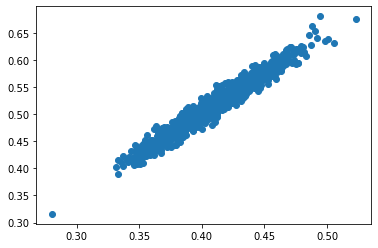

In [ ]:
# del predictor
predictor = Predictor(2, 1)
loss_fn = torch.nn.MSELoss(reduction='sum')
loss_track, param_track = predictor_training(predictor, loss_fn, arr, y, epochs=100)
plt.scatter(predictor.get_approx().data.numpy(), y.data.numpy())

In [ ]:
predictor = predictor.eval()
for param in predictor.parameters():
    param.requires_grad = False
predictor.parameters

<bound method Module.parameters of Predictor(
  (fc): Linear(in_features=2, out_features=1, bias=True)
)>

In [ ]:
model = TrainedPred_VAE(2, 1, 1, predictor)
resloss_fn = KLDiv_Loss(reduction='mean')
predloss_fn = torch.nn.MSELoss(reduction='mean')
loss_track, param_track = predictivevae_training(model, resloss_fn, predloss_fn, arr, y, 500, predloss_weight=0.8)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


+ Loss = 0.905525
      Reconstruction Loss = 0.393177, Prediction Loss = 1.033611
+ Param:  {'mu': array(-0.13608137, dtype=float32), 'logvar': array(-0.18156484, dtype=float32)}
+ Loss = 0.286982
      Reconstruction Loss = 0.094058, Prediction Loss = 0.335213
+ Param:  {'mu': array(-0.1386531, dtype=float32), 'logvar': array(-0.17286505, dtype=float32)}
+ Loss = 0.109783
      Reconstruction Loss = 0.040786, Prediction Loss = 0.127032
+ Param:  {'mu': array(-0.13619837, dtype=float32), 'logvar': array(-0.17069043, dtype=float32)}
+ Loss = 0.078293
      Reconstruction Loss = 0.028752, Prediction Loss = 0.090678
+ Param:  {'mu': array(-0.13396543, dtype=float32), 'logvar': array(-0.16997439, dtype=float32)}
+ Loss = 0.053587
      Reconstruction Loss = 0.003041, Prediction Loss = 0.066223
+ Param:  {'mu': array(-0.13422132, dtype=float32), 'logvar': array(-0.1697026, dtype=float32)}
+ Loss = 0.042318
      Reconstruction Loss = -0.003503, Prediction Loss = 0.053773
+ Param:  {'mu': a

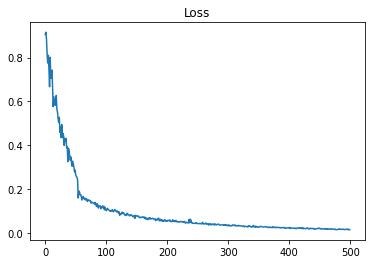

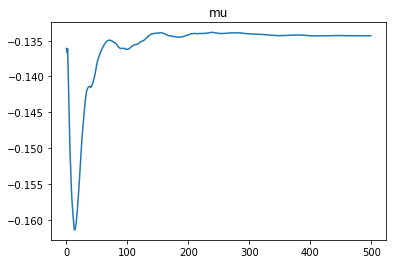

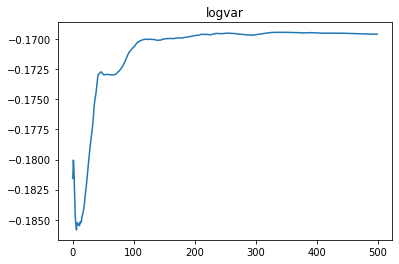

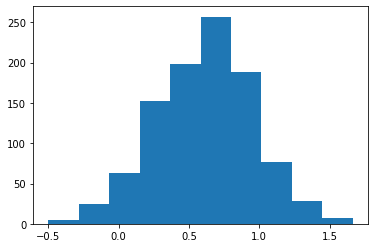

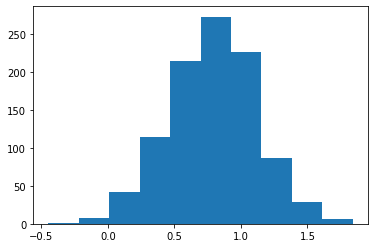

In [ ]:
visualize(loss_track, param_track, model.get_approx()[0].data.numpy())

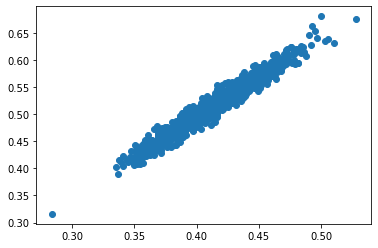

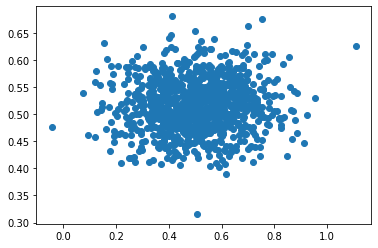

In [ ]:
plt.scatter(model.predictor(arr), y.data.numpy())
plt.show()
plt.scatter(model.get_approx()[1].data.numpy(), y.data.numpy())
plt.show()

In [ ]:
# model = TrainedPred_VAE(2, 1, 1, predictor)
loss_track, param_track = predictivevae_training(model, resloss_fn, predloss_fn, arr, y, 500, predloss_weight=0.8)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


+ Loss = 0.015121
      Reconstruction Loss = -0.032883, Prediction Loss = 0.027121
+ Param:  {'mu': array(-0.13431413, dtype=float32), 'logvar': array(-0.16957489, dtype=float32)}
+ Loss = 0.007268
      Reconstruction Loss = -0.038179, Prediction Loss = 0.018630
+ Param:  {'mu': array(-0.134275, dtype=float32), 'logvar': array(-0.16954055, dtype=float32)}
+ Loss = 0.002779
      Reconstruction Loss = -0.038810, Prediction Loss = 0.013177
+ Param:  {'mu': array(-0.13425562, dtype=float32), 'logvar': array(-0.16954578, dtype=float32)}
+ Loss = -0.000035
      Reconstruction Loss = -0.041896, Prediction Loss = 0.010430
+ Param:  {'mu': array(-0.13426116, dtype=float32), 'logvar': array(-0.16954851, dtype=float32)}
----Early stopping----


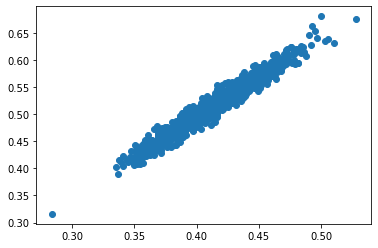

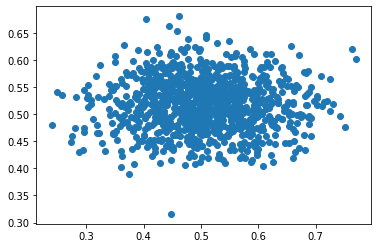

In [ ]:
plt.scatter(model.predictor(arr), y.data.numpy())
plt.show()
plt.scatter(model.get_approx()[1].data.numpy(), y.data.numpy())
plt.show()

## Pretrained-Predictor Sampling VAE

In [ ]:
# class Encoder(torch.nn.Module):
#     def __init__(self, input_dim, latent_dim):
#         super().__init__()
#         self.fc1 = torch.nn.Linear(input_dim, latent_dim[0])
#         self.relu = torch.nn.ReLU()
#         self.fcmean = torch.nn.Linear(latent_dim[0], latent_dim[1])
#         self.fclogvar = torch.nn.Linear(latent_dim[0], latent_dim[1])
#         self.mu, self.logvar = None, None

#     def forward(self, inputs):
#         self.h = self.relu(self.fc1(inputs))
#         self.mu = self.fcmean(self.h)
#         self.logvar = self.fclogvar(self.h)
#         return self.mu, self.logvar

# def sampling(args):
#     t_mean, t_logvar = args
#     t_sigma = torch.exp(0.5 * t_logvar)
#     epsilon = torch.randn(t_mean.shape)
#     t_hat = t_mean + epsilon * t_sigma
#     return t_hat

# class Decoder(torch.nn.Module):
#     def __init__(self, input_dim, latent_dim):
#         super().__init__()
#         self.fc1 = torch.nn.Linear(latent_dim[1], latent_dim[0])
#         self.relu = torch.nn.ReLU()
#         self.fc2 = torch.nn.Linear(latent_dim[0], input_dim)
#         self.sigmoid= torch.nn.Sigmoid()
#         self.mu = None

#     def forward(self, inputs):
#         self.h = self.relu(self.fc1(inputs))
#         self.mu = self.sigmoid(self.fc2(self.h))
#         return self.mu

In [ ]:
# class Sampling_VAE(torch.nn.Module):
#     def __init__(self, input_dim, latent_dim):
#         super().__init__()
#         self.encoder = Encoder(input_dim, latent_dim)
#         self.decoder = Decoder(input_dim, latent_dim)
#         self.training = True

#     def forward(self, inputs):
#         t_mean, t_logvar = self.encoder(inputs)
#         t_hat = sampling((t_mean, t_logvar))
#         print ('t', t_hat.shape)
#         x_mean = self.decoder(t_hat)
#         print ('x', x_mean.shape)
#         return t_hat, x_mean

#     def get_param(self):
#         return {'mu':self.encoder.mu.data.numpy(), 'logvar':self.encoder.logvar.data.numpy()}

#     def get_approx(self, n_sample=1000):
#         return self.decoder.mu

In [ ]:
# def vae_training(model, loss_fn, obs, epochs=500):
#     optim   = torch.optim.Adam(model.parameters(), lr=0.001)
#     view_step = epochs/10
#     loss_track, param_track = [], []

#     for step in range(epochs):
#         # Computing Loss
#         posterior, outputs = model(obs)
#         loss = loss_fn(outputs, obs)
#         loss_track.append(loss)
#         param_track.append(model.get_param())

#         # Tracking
#         if (loss < 0) or (step==0) or (step % view_step == view_step-1):
#             print ('+ Loss = %.6f' % loss)
#             print ('+ Param: ', param_track[-1])
#             if (loss < 0):
#                 print ("----Early stopping----")
#                 break

#         # Optimizing
#         optim.zero_grad()
#         loss.backward()
#         optim.step()
#     return loss_track, param_track

In [ ]:
# model = Sampling_VAE(2, [6,4])
# loss_fn = ELBO_Loss(reduction='sum')
# loss_track, param_track = vae_training(model, loss_fn, arr, 1000)

t torch.Size([1000, 4])
x torch.Size([1000, 2])
+ Loss = -2124.672363
+ Param:  {'mu': array([[-0.14225495,  0.12363734, -0.14318728,  0.45344377],
       [-0.24244842,  0.09942238, -0.13677457,  0.48429027],
       [-0.20231766,  0.10188826, -0.14352208,  0.4787928 ],
       ...,
       [-0.13890672,  0.10597588, -0.13541713,  0.45147538],
       [-0.13553184,  0.10620358, -0.13399062,  0.44903356],
       [-0.15960589,  0.10457936, -0.14416632,  0.46645188]],
      dtype=float32), 'logvar': array([[ 0.3736352 , -0.11257167,  0.20989826,  0.11086111],
       [ 0.4035843 , -0.14833239,  0.22453743,  0.12702192],
       [ 0.38621134, -0.13733184,  0.20901656,  0.11871848],
       ...,
       [ 0.3636366 , -0.10930262,  0.21129383,  0.11813217],
       [ 0.36269373, -0.10724624,  0.21283627,  0.11876561],
       [ 0.3694197 , -0.12191496,  0.2018337 ,  0.11424712]],
      dtype=float32)}
----Early stopping----
